In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset

import lightning as L
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.loggers import CSVLogger

import nltk

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('universal_tagset')

from scripts.feature_extraction import load_features, perform_feature_extraction, save_features
from scripts.network import Pan2425Dataset, FullyConnectedNeuralNetwork

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/maxneerken/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/maxneerken/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/maxneerken/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
/Users/maxneerken/Documents/Text & Multimedia Mining/Assignment 4/scripts/feature_extraction.py:105: SyntaxWarning: invalid escape sequence '\ '
  """
/Users/maxneerken/Documents/Text & Multimedia Mining/Assignment 4/scripts/feature_extraction.py:134: SyntaxWarning: invalid escape sequence '\w'
  return len(re.findall("\w+[\"']\w+", text))


## Data retrieval

In [2]:
data = {
    'dev': pd.read_csv('data/pan2425_dev_data.csv'),
    'train': pd.read_csv('data/pan2425_train_data.csv'),
    'test': pd.read_csv('data/pan2425_test_data.csv')
}

## Feature extraction

In [3]:
extract = False

author_mapping = {560480: 0, 512464: 1, 2750536: 2, 1112924: 3, 29783: 4, 910821: 5, 1497577: 6, 748687: 7,
                  1220273: 8, 870118: 9, 1276465: 10, 2943978: 11, 806976: 12, 2855986: 13, 6234395: 14,
                  240213: 15, 583064: 16, 583994: 17, 967934: 18, 3439302: 19}

if extract:
    train_features, train_labels = perform_feature_extraction(data['train'], author_mapping)
    save_features(train_features, train_labels, './data', 'train')
    
    val_features, val_labels = perform_feature_extraction(data['train'], author_mapping)
    save_features(val_features, val_labels, './data', 'train')
else:
    train_features, train_labels = load_features('./data', 'train')
    val_features, val_labels = load_features('./data', 'val')

## Training

In [5]:
train_set = Pan2425Dataset(train_features, np.array(train_labels))
val_set = Pan2425Dataset(val_features, np.array(val_labels))

train_loader = DataLoader(train_set, shuffle=True, batch_size=64)
val_loader = DataLoader(val_set, shuffle=False, batch_size=64)

In [6]:
val_set.__getitem__(2)

(tensor([3.0390e+03, 4.3000e+01, 6.7300e+02, 1.2000e+01, 2.7000e+01, 6.3000e+01,
         0.0000e+00, 3.0000e+00, 0.0000e+00, 7.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
         3.5000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+01,
         8.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 4.9034e-02,
         9.5097e-02, 7.8752e-02, 0.0000e+00, 0.0000e+00, 6.2407e-02, 0.0000e+00,
         1.9316e-01, 4.4577e-03, 0.0000e+00, 1.2184e-01, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.6939e-01, 2.9718e-03, 6.3179e-02, 1.0859e-02,
         1.6782e-02, 3.0931e-02, 8.4238e-02, 1.3162e-02, 2.2705e-02, 4.9358e-02,
         6.6469e-02, 1.3162e-03, 1.0859e-02, 3.1589e-02, 1.3820e-02, 5.4294e-02,
         5.9559e-02, 1.4478e

In [7]:
from torch.nn.functional import cross_entropy


class FullyConnectedNeuralNetwork(L.LightningModule):
    def __init__(self, n_features=175, n_authors=20, learning_rate=0.0001):
        super().__init__()

        self.net = torch.nn.Sequential(
            torch.nn.Linear(n_features, 300),
            torch.nn.ReLU(),
            torch.nn.Linear(300, 200),
            torch.nn.ReLU(),
            torch.nn.Linear(200, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, n_authors),
            # torch.nn.Softmax(dim=1) # Softmax is applied in loss function.
        )

        self.learning_rate = learning_rate

    def training_step(self, batch, batch_idx):
        features, labels = batch

        output = self.forward(features)
        loss = cross_entropy(output, labels)

        return loss

    def validation_step(self, batch, batch_idx):
        features, labels = batch

        output = self.forward(features)
        loss = cross_entropy(output, labels)

        prediction = torch.argmax(output, dim=1)
        accuracy = torch.mean((prediction == labels).float())

        self.log("val_loss", loss, on_epoch=True)
        self.log("val_accuracy", accuracy, on_epoch=True)

    # def test_step(self, batch, batch_idx):
    #     features, labels = batch
    # 
    #     output = self.forward(features)
    #     prediction = torch.argmax(output, dim=1)
        
        

    def forward(self, x):
        return self.net.forward(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())


In [9]:
net = FullyConnectedNeuralNetwork()

In [10]:

import warnings

warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", ".*is smaller than the logging interval.*")

logger = CSVLogger('./lightning_logs/', name=None)
trainer = L.Trainer(logger=logger, limit_train_batches=100, max_epochs=100)
# , callbacks=[EarlyStopping(monitor='val_loss', mode='min')])
trainer.fit(model=net, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 135 K  | train
--------------------------------------------
135 K     Trainable params
0         Non-trainable params
135 K     Total params
0.540     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 34/34 [00:03<00:00, 10.58it/s, v_num=15]         
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 34/34 [00:00<00:00, 37.78it/s, v_num=15]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 34/34 [00:01<00:00, 33.31it/s, v_num=15]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 36.92it/s, v_num=15]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 34/34 [00:01<00:00, 32.18it/s, v_num=15]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 34/34 [00:00<00:00, 35.94it/s, v_num=15]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 34/34 [00:00<00:00, 43.10it/s, v_num=15]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 34/34 [00:00<00:00, 39.10it/s, v_num=15]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 34/34 [00:01<00:00,

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 34/34 [00:01<00:00, 27.49it/s, v_num=15]


## Model evaluation

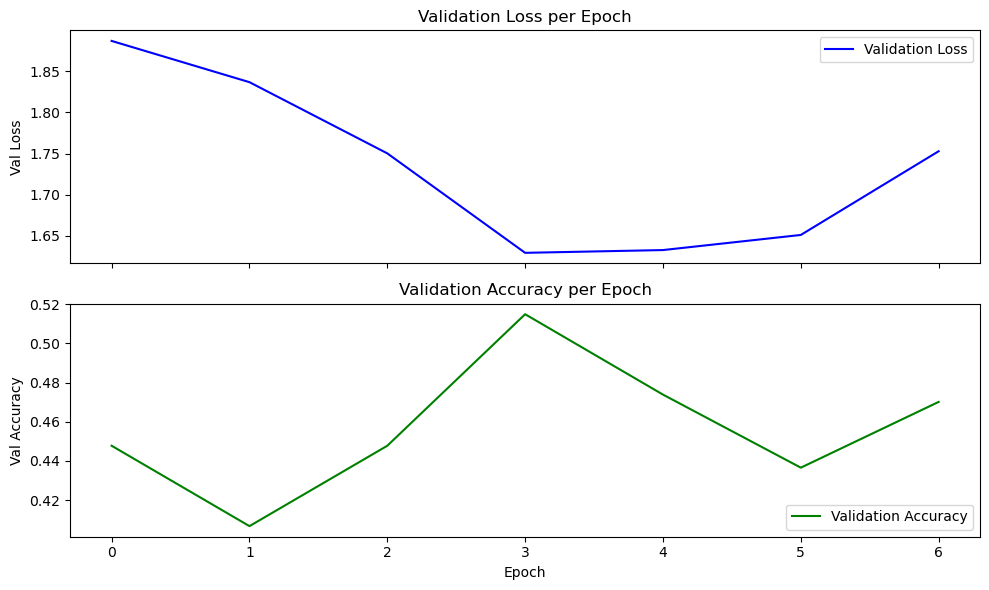

In [9]:
# Load the metrics CSV file
metrics = pd.read_csv('./lightning_logs/version_5/metrics.csv', na_values='')

# Drop rows with NaN values in 'epoch', 'val_loss', or 'val_accuracy'
metrics.dropna(subset=['epoch', 'val_loss', 'val_accuracy'], inplace=True)

# Extract data for plotting
epochs = metrics['epoch']
val_loss = metrics['val_loss']
val_accuracy = metrics['val_accuracy']

# Plot val_loss and val_accuracy per epoch
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Subplot for validation loss
ax1.plot(epochs, val_loss, label='Validation Loss', color='blue')
ax1.set_title("Validation Loss per Epoch")
ax1.set_ylabel("Val Loss")
ax1.legend(loc="upper right")

# Subplot for validation accuracy
ax2.plot(epochs, val_accuracy, label='Validation Accuracy', color='green')
ax2.set_title("Validation Accuracy per Epoch")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Val Accuracy")
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [98]:
test_features, test_labels = perform_feature_extraction(data['test'], author_mapping)
test_set = Pan2425Dataset(test_features, test_labels)
test_loader = DataLoader(test_set, shuffle=False, batch_size=64)

results = trainer.test(net, test_loader)

TypeError: perform_feature_extraction() takes 1 positional argument but 2 were given

## Ablation analysis